In [2]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
#from tauccML_GNN import TwoGNN 
from torch_geometric.utils import degree
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import normalized_mutual_info_score as nmi
#from sklearn.metrics import adjusted_rand_score as ari
import random
import os


if torch.cuda.is_available() :
  print(f"CUDA is supported by this system. \nCUDA version: {torch.version.cuda}")
  dev = "cuda:0"
else :
  dev = "cpu"

print(f"Device : {dev}")
device = torch.device(dev) 

CUDA is supported by this system. 
CUDA version: 11.8
Device : cuda:0


In [3]:

def adj_correlation(data,percentile = 90):
  adj = np.corrcoef(data)
  adj[np.isnan(adj)] = 0
  adj[adj < np.percentile(adj,percentile)] = 0

  
  return adj

def adj_cooccurence(data, percentile = 90):
  data = torch.from_numpy(data).to(torch.float32).to(device)
  adj = data@data.T
  adj = adj.fill_diagonal_(0).cpu()
  #adj[adj < np.percentile(adj,percentile)] = 0

  return adj

In [22]:
dataset ="sports"

input_CSV = pd.read_csv(f'./datasets/{dataset}.txt')

table_size_x = len(input_CSV.doc.unique())
table_size_y = len(input_CSV.word.unique())
input_table = np.zeros((table_size_x,table_size_y), dtype = int)
for row in input_CSV.iterrows():
    input_table[row[1].doc,row[1].word] = row[1].cluster

print(table_size_x,table_size_y)


3891 4303


In [ ]:
adj = adj_correlation(input_table.T)
edges = torch.from adj.nonzero().t().contiguous()


numbers = Counter(degree(edges[0]).numpy())

print(len(edges[0]))
print(max(numbers.keys()))
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

AttributeError: 'tuple' object has no attribute 't'

1.0


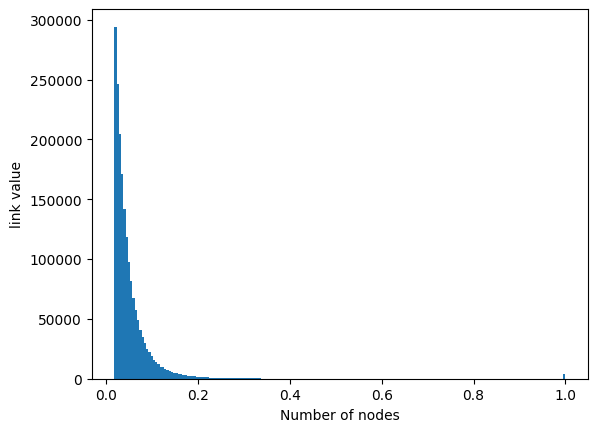

In [7]:
adj = adj.flatten()
print(adj.max())
fig, ax = plt.subplots()
ax.set_xlabel('Number of nodes')
ax.set_ylabel('link value')
plt.hist(adj[adj>0],200)
plt.show()

In [7]:
print(adj)

[0 1 0 ... 3 5 0]


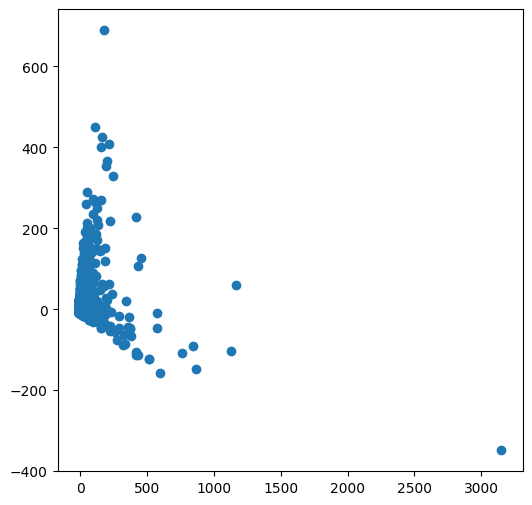

In [29]:

pca = PCA(n_components=2)
X = pca.fit_transform(input_table.T)
plt.figure(figsize = (6,6))
plt.scatter(*zip(*X))
#print(X)

In [3]:
datasets = ["cstr", "tr11", "classic3", "hitech", "k1b", "reviews", "sports"]
explained_variance = 0.8
pca = PCA(explained_variance)
scaler = StandardScaler()

for dataset in datasets:
    input_CSV = pd.read_csv(f'./datasets/{dataset}.txt')
    target_CSV = pd.read_csv(f'./datasets/{dataset}_target.txt', header = None)
    target = np.array(target_CSV).T[0]

    table_size_x = len(input_CSV.doc.unique())
    table_size_y = len(input_CSV.word.unique())
    input_table = np.zeros((table_size_x,table_size_y), dtype = int)

    for row in input_CSV.iterrows():
        input_table[row[1].doc,row[1].word] = row[1].cluster

    print(input_table)
    break

 

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [33]:
dataset = 'sports'
np.load(f'./data/{dataset}.npy').shape

(8580, 14870)

In [ ]:
I = 10 
M = 100
O = 100

a = torch.randint(-20,0,(I,M))
b = torch.randint(-20,0,(M,M))
c = torch.randint(-20,0,(M,M))
d = torch.randint(-20,0,(M,O))

torch.argmax(a@b@c@d,dim=1)

In [ ]:
def set_seed(seed: int = 42) -> None:
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  # When running on the CuDNN backend, two further options must be set
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  # Set a fixed value for the hash seed
  os.environ["PYTHONHASHSEED"] = str(seed)
  print(f"Random seed set as {seed}")

# Fix seed


In [ ]:
# load data
dataset = 'cstr' #, cstr, tr11, tr41, hitech, k1b, reviews, sports, classic3
init = 'extract_centroids' # this is the only initialization considered in the paper UNUSED

input_CSV = pd.read_csv(f'./datasets/{dataset}.txt')
target_CSV = pd.read_csv(f'./datasets/{dataset}_target.txt', header = None)
target = np.array(target_CSV).T[0]

table_size_x = len(input_CSV.doc.unique())
table_size_y = len(input_CSV.word.unique())
input_table = np.zeros((table_size_x,table_size_y), dtype = int)

for row in input_CSV.iterrows():
  input_table[row[1].doc,row[1].word] = row[1].cluster

In [ ]:
set_seed()
hidden_size = 256
embedding_size = 5
num_epochs = 2
input_dimx = table_size_x
input_dimy = table_size_y
hidden_dim = hidden_size
output_dim = embedding_size
num_layers = 4
learning_rate = 1e-5
exp_schedule = 0.9
dtype = torch.float32

print("dimensions",table_size_x,table_size_y)
data = torch.from_numpy(input_table).to(dtype).to(device)
gnn_model = TwoGNN(input_dimx, input_dimy, hidden_dim, output_dim, num_layers, learning_rate, exp_schedule, data, device)

x = data
correlation_coefficient = np.corrcoef(x.cpu())
correlation_coefficient[np.isnan(correlation_coefficient)] = 0
correlation_coefficient.clip(min = 0)

adjx =  torch.from_numpy(correlation_coefficient).to(dtype).to(device)

y = data.T
correlation_coefficient = np.corrcoef(y.cpu())
correlation_coefficient[np.isnan(correlation_coefficient)] = 0
correlation_coefficient.clip(min = 0)
adjy =  torch.from_numpy(correlation_coefficient).to(dtype).to(device)


In [ ]:
set_seed()
from torch.nn.functional import gelu, softmax,relu
input_layer = torch.nn.Linear(table_size_x,hidden_dim).to(device)
hidden_layer1 = torch.nn.Linear(hidden_dim,hidden_dim).to(device)
hidden_layer2 = torch.nn.Linear(hidden_dim,hidden_dim).to(device)
output_layer = torch.nn.Linear(table_size_y,embedding_size).to(device)
a = torch.ones(table_size_x,5).to(dtype).to(device)
#message_passing = adjy @ a
weights = torch.randn((5,embedding_size)).to(dtype).to(device)
out= relu(adjx@a@weights)
print(out.sum(dim=0))
print(out)


classification = softmax(out,dim=1)


print(classification.sum(dim=0))
lin = torch.nn.Linear(hidden_dim,hidden_dim).to(device)
#f = lambda x : gelu(lin(adjy @ x))

In [ ]:
#256221.9375 0.0484
#370616.9688 0.0036
adjy.mean(),adjx - adjx.mean()

In [ ]:
set_seed()

print("training start")
gnn_model.fit(x, adjx, y, adjy, num_epochs, embedding_size)

print("training end")

In [ ]:
print("target :", target, "\n")


gnn_model.row_labels_ = torch.argmax(gnn_model.row_labels_, dim=1)
print("predicted row labels :", gnn_model.row_labels_,"\n")

print(f"nmi: {nmi(target, gnn_model.row_labels_.cpu())}")
print(f"ari: {ari(target, gnn_model.row_labels_.cpu())}")

In [ ]:
fig, ax = plt.subplots()
ax.plot(gnn_model.tau_x)
ax.plot(gnn_model.tau_y)
plt.plot([(gnn_model.tau_x[i] + gnn_model.tau_y[i])/2 for i in range(len(gnn_model.tau_x))])
ax.legend(['tau x','tau y','avg tau'])
ax.set_xlabel('iterations')
ax.set_ylabel('tau')
plt.show()